# Análisis de usuarios de Spotify

En este cuaderno vamos a llevar a cabo un análisis de las canciones escuchadas por un usuario, basándonos en las playlist que tiene el mismo. Para esto vamos a comparar los gustos de dos de los integrantes del grupo, analizando las tendencias musicales de cada uno, siguiendo distintas características que indicaremos más abajo. 

Antes de todo esto ejecutaremos un script de python que hemos desarrollado para obtener todas las canciones que un usuario tiene en sus playlists, mediante el acceso al API de spotify. Se puede acceder a todo lo que hemos desarrollado y utilizado en el siguiente repositorio: https://github.com/Mormur22/SpotifyRecomendator

Una vez el análisis esté hecho desarrollaremos un modelo que pueda predecir, dada una canción, si es más probable que pertenezca a un integrante del grupo o otro 

Antes de nada, cabe destacar que spotify mide las canciones de su base de datos siguiendo distintos parametros, vamos a mostrar el conjunto de datos de un usuario y a continuación explicaremos que significa cada columna

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df_dani = pd.read_csv('danicp014-playlists.csv')
df_dani

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
0,0.820,0.5630,91.034,0.0874,0.0536,0.00000,4,0.693,7,199451,-4.761,0.6040,1,spotify:track:0X8Cti1dfb4wCRiuW7O1lA,341 Lords,Ill Pekeño
1,0.855,0.1380,168.583,0.3800,0.0844,0.00000,4,0.425,10,171429,-6.519,0.3980,0,spotify:track:3JIdMvH3D07jrN0LD5LfYM,Av. Rafaela Ybarra,Ill Pekeño
2,0.646,0.1000,87.847,0.3610,0.1950,0.00000,4,0.791,4,196364,-8.586,0.5890,0,spotify:track:0hwacTqU4grF4gD68dE4fj,AMG,Ill Pekeño
3,0.534,0.0949,87.215,0.3450,0.6080,0.00576,4,0.665,10,198621,-9.749,0.8580,0,spotify:track:0nDFRlto0k3TTpNONZ2dWe,Calle Cortada,Ill Pekeño
4,0.601,0.3100,82.941,0.3640,0.0317,0.00000,4,0.424,9,167347,-8.153,0.4160,0,spotify:track:68dxVhzivEJYn2Epw39jdh,Tierra Abatida,Ill Pekeño
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.569,0.3360,120.531,0.0386,0.2660,0.00000,4,0.497,9,182667,-10.632,0.8110,1,spotify:track:40XXjm2pU6LGZkLq5VmkaQ,Everlasting Love,Love Affair
1076,0.273,0.1090,132.285,0.0380,0.9400,0.43100,5,0.365,4,248960,-16.526,0.2380,0,spotify:track:5GbVzc6Ex5LYlLJqzRQhuy,Mystery of Love,Sufjan Stevens
1077,0.719,0.4110,95.769,0.0266,0.0613,0.00000,4,0.497,6,255733,-9.397,0.5470,1,spotify:track:15MJ5NThPjj6xhPcts8MiY,"Take My Breath Away - Love Theme from ""Top Gun""",Berlin
1078,0.632,0.0821,108.291,0.0456,0.3160,0.00576,4,0.625,10,300063,-7.867,0.0869,0,spotify:track:6VfKhnmbqCj14zcjZNjZTk,Running Up That Hill (A Deal with God),Kate Bush


Como se puede ver en la documentación de spotify (https://developer.spotify.com/documentation/web-api/reference/get-audio-features) estas son las características
- Instrumentalness: Describe cuánto de instrumental es una canción. Cuánto más cerca es a 1.0, la canción es más instrumental
- Acousticness: Describe cuán acústica es una canción. Una puntuación 1.0 significa que la canción es una versión acústica.
- Liveness: Este valor describe la probabilidad de que la canción haya sido grabada con público en directo. Según la documentación oficial “un valor sobre 0.8 significa que muy probablemente haya sido grabada con público en vivo”.
- Speechiness: “Speechiness detecta la presencia de frases no cantadas en una canción”. si el valor de speechiness en una canción supera el 0.66, está probablemente compuesta de palabras no cantadas, una puntuación entre 0.33 y 0.66 es una cancion que puede contener tanto musica como palabras, y una puntuación debajo de 0.33 significa que la canción no tiene ningun discurso 
- Energy: “La energía representa una medida perceptual de intensidad y actividad. Normalmente, las canciones energeticas se sienten rápidas y ruidosas”.
- Danceability: “Danceability describe como que de adecuada es una canción para bailar basada en la combinación de elementos musicales incluyendo el tempo, la estabilidad rítmica, la fuerza del beat, y la regularidad media. Un valor de 0.0 indica que es una canción muy poco bailable”.
- Valence: “Una medida desde 0.0 hasta 1.0 que describe la positivad musical de una canción. Las canciones con gran valor de valence suenan más positivas mientras que las canciones con un bajo valor suenan más neagativas”.

### Análisis de los datos

Antes de pasar a analizar los resultados vamos a jugar un poco con el csv para ver qué estilo de canciones tiene este usuario

In [3]:
# Vamos a ver que canción es la más enérgica y la que menos de todas las que tiene guardadas:
df_dani[df_dani.energy == df_dani.energy.max()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
612,0.981,0.438,82.331,0.059,0.0178,0.000002,4,0.549,11,185307,-3.558,0.873,0,spotify:track:0C9jZPUv4SuaXkuEQw6L40,I'm A Believer,Smash Mouth


In [4]:
df_dani[df_dani.energy == df_dani.energy.min()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
1072,0.00862,0.122,95.209,0.131,0.794,0.0,3,0.61,8,79975,-19.671,0.288,1,spotify:track:3BhySSBUXy9EpKucV8b7cV,Downtown - A Capella,Anya Taylor-Joy


En el ejemplo anterior vemos que la canción con mayor energía es la popular canción de 'Shrek', 'I'm a believer', mientras que la canción con menor energía es una versión a capella de 'Downtown', perteneciente a la banda sonora de la película 'Last Night in Soho'. Como vemos el resultado tiene bastante sentido conociendo ambas canciones

In [5]:
# Vamos a ver cuál es la canción más larga que tiene guardada y cual es la de menor duración:
df_dani[df_dani.duration_ms == df_dani.duration_ms.max()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
967,0.18,0.0733,145.142,0.0475,0.984,0.921,3,0.246,4,660092,-19.032,0.0393,0,spotify:track:3YgkhUApzoeBzu5dEl24Bt,Oltremare,Ludovico Einaudi


In [6]:
df_dani[df_dani.duration_ms == df_dani.duration_ms.min()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
509,0.151,0.0776,139.616,0.526,0.894,0.000002,4,0.597,6,52042,-14.481,0.382,1,spotify:track:4qypIShMdrtUhOoQ83GHPl,Galaxy,JID


En este caso vemos que la canción más larga es 'Oltremare' de Ludovico Eunadi que tiene una duración de 11 minutos, mientras que 'Galaxy' de Jid tiene una duración de 52 segundos

A continuación vamos a analizar las tendencias de otro miembro del grupo:

In [14]:
df_alex = pd.read_csv('Alexmor_22-playlists.csv')
df_alex

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
0,0.504,0.1400,98.077,0.1950,0.606,0.005670,4,0.742,1,110944,-8.596,0.494,1,spotify:track:0VhfZo2uwcWnQGExuOxNKq,Ojo de Halcón,Hoke
1,0.534,0.0949,87.215,0.3450,0.608,0.005760,4,0.665,10,198621,-9.749,0.858,0,spotify:track:0nDFRlto0k3TTpNONZ2dWe,Calle Cortada,Ill Pekeño
2,0.669,0.1140,133.887,0.2820,0.517,0.000025,4,0.772,8,207313,-6.107,0.858,0,spotify:track:1fyCvJYDqc6ieWbvf0k1Vy,Jjjj,Hoke
3,0.681,0.1590,90.273,0.3990,0.621,0.000000,4,0.670,5,197333,-8.557,0.712,1,spotify:track:51kzHiwV2gqYOakB0HGh8d,Desamparados,Hoke
4,0.669,0.1300,133.931,0.1340,0.382,0.000423,4,0.861,11,152239,-6.806,0.776,0,spotify:track:7cGa3beFdDoIzys3xMDV1G,Olympique,Hoke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,0.442,0.1580,105.025,0.0249,0.443,0.614000,4,0.584,9,303507,-10.994,0.360,0,spotify:track:28U855g6cGv2O3s5KzUcdr,White Flag,Fink
2619,0.195,0.1010,93.071,0.0300,0.673,0.002540,4,0.378,11,240813,-12.423,0.356,1,spotify:track:1JEjCzwE9viGiRyewkcWy9,Sleepless in Seattle,Noah Gundersen
2620,0.185,0.3590,77.374,0.0311,0.927,0.000009,4,0.423,5,205427,-9.339,0.160,1,spotify:track:3eOowx1zDomY1YC1UDKDKn,"I'm Tired, You're Lonely",Liza Anne
2621,0.426,0.0976,148.063,0.0310,0.760,0.392000,4,0.453,9,394320,-12.793,0.356,1,spotify:track:5eSH7Aubn6Ol80ynF4MV2L,Nica Libres At Dusk,Ben Howard


In [8]:
# Vamos a ver que canción es la más enérgica y la que menos de todas las que tiene guardadas:
df_alex[df_alex.energy == df_alex.energy.max()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
1263,0.994,0.303,94.956,0.125,0.000044,0.000859,4,0.422,8,208954,-2.686,0.151,1,spotify:track:4hgvghKCZJ3YZgZmJ5I2ht,Kill The Hero,Black Veil Brides


In [9]:
df_alex[df_alex.energy == df_alex.energy.min()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist
2437,0.0144,0.114,87.474,0.032,0.855,0.000332,1,0.229,2,99680,-30.935,0.247,0,spotify:track:1yJzoX4xPsACzVxUarXRKa,Misty Mountains,Richard Armitage


Vamos a ver primero las características que valoran verdaderamente la canción, es decir, primero vamos a descartar valores como la duración o el tempo para centrarnos en aquellas que verdaderamente dan el carácter especial a las canciones. 

In [10]:
df_dani_mean = df_dani.mean(numeric_only=True)
df_dani_mean

energy                   0.501312
liveness                 0.177272
tempo                  117.876954
speechiness              0.111784
acousticness             0.452206
instrumentalness         0.097040
time_signature           3.885185
danceability             0.569070
key                      5.108333
duration_ms         217708.743519
loudness                -9.554365
valence                  0.394341
mode                     0.525000
dtype: float64

In [11]:
df_dani_mean = df_dani_mean.drop(['duration_ms', 'tempo', 'loudness', 'key', 'time_signature', 'mode'])

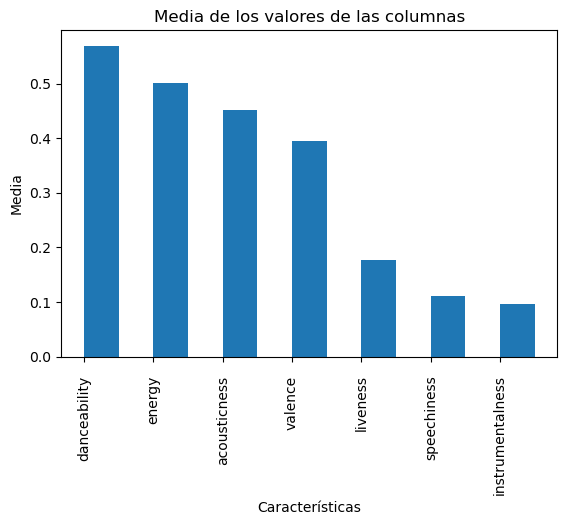

In [12]:
df_dani_mean = df_dani_mean.sort_values(ascending=False)


plt.bar(df_dani_mean.index, df_dani_mean, width=0.5, align='edge')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.tick_params(axis='x', which='major', pad=10)
plt.xlabel('Características')
plt.ylabel('Media')
plt.title('Media de los valores de las columnas')
plt.show()

In [13]:
df_alex_mean = df_alex.mean(numeric_only=True)
df_alex_mean

energy                   0.619118
liveness                 0.179370
tempo                  122.188937
speechiness              0.071429
acousticness             0.309638
instrumentalness         0.090753
time_signature           3.924133
danceability             0.543675
key                      5.211209
duration_ms         222975.579489
loudness                -8.240475
valence                  0.430206
mode                     0.667556
dtype: float64

In [14]:
df_alex_mean = df_alex_mean.drop(['duration_ms', 'tempo', 'loudness', 'key', 'time_signature', 'mode'])

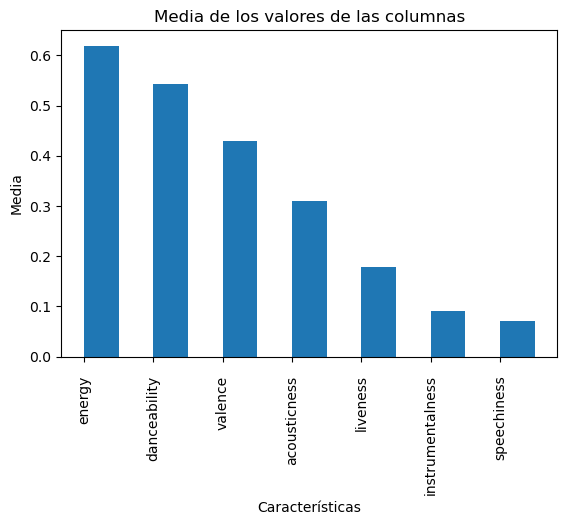

In [15]:
df_alex_mean = df_alex_mean.sort_values(ascending=False)


plt.bar(df_alex_mean.index, df_alex_mean, width=0.5, align='edge')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.tick_params(axis='x', which='major', pad=10)
plt.xlabel('Características')
plt.ylabel('Media')
plt.title('Media de los valores de las columnas')
plt.show()

In [16]:
df_dani_mean = pd.DataFrame(df_dani_mean).sort_index()
df_alex_mean = pd.DataFrame(df_alex_mean).sort_index()

                         0
acousticness      0.142568
danceability      0.025395
energy           -0.117806
instrumentalness  0.006287
liveness         -0.002098
speechiness       0.040355
valence          -0.035865


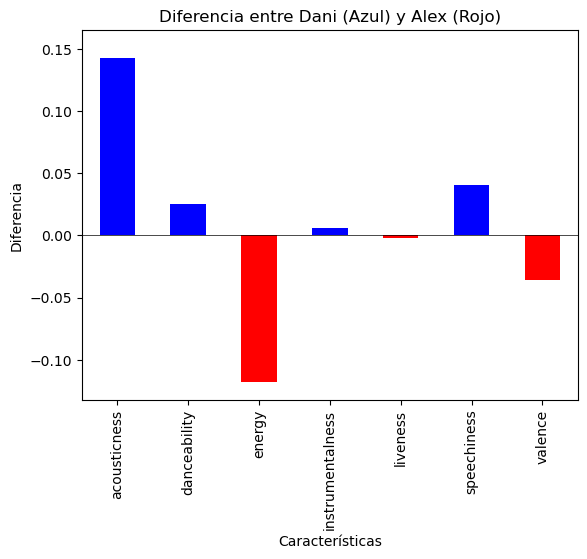

In [37]:
df_diferencia = pd.DataFrame(df_dani_mean - df_alex_mean)
print(df_diferencia)

# Valores minimos y maximos de la diferencia
ymin = -0.12 * 1.1 
ymax = 0.15 * 1.1 

fig, ax = plt.subplots()

x_range = range(7)
bar_width = 0.5

data = [item for sublist in df_diferencia.values.tolist() for item in sublist]

bars = ax.bar(x_range, data, width=bar_width, color=['r' if x < 0 else 'b' for x in data])

ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlim([-0.5, 7-0.5])
ax.set_ylim([ymin, ymax])
ax.set_xticks(x_range)
ax.set_xticklabels(labels, rotation=90)

ax.set_title('Diferencia entre Dani (Azul) y Alex (Rojo)')
ax.set_xlabel('Características')
ax.set_ylabel('Diferencia')
plt.show()

El diagrama anterior muestra la diferencia entre la música escuchada por Dani y la música escuchada por Alex. Vemos que hay dos características en las que se puede apreciar más diferencia y estas son 'acousticness' y 'energy'.

Alex, por su parte, tiene una mayor tendencia a escuchar música más energética que la música que suele escuchar Dani. Esto tiene sentido ya que uno de los generos favoritos de Alex es el rock, que suele ser mucho más enérgica que la música que Dani suele escuchar, más cercano al R&B.
Dani, por su parte, tiene una mayor tendencia a escuchar canciones más acústicas que Alex. De hecho es en esta característica dónde encontramos mayor disparidad, un valor de 0.14.

También se puede apreciar, en muchísima menor medida ya que los valores difieren por muy pocos puntos, que la música de Alex suele ser más positiva (valence) mientras que la de Dani es más apropiada para bailar y contiene más discursos (lo que tiene sentido sabiendo que el rap es uno de sus géneros más escuchados)

### ¿Quién escucha música más variada de los dos?

Para contestar a esta pregunta, hemos investigado cómo de similares o diferentes son las canciones de cada playlist. Por ejemplo, una playlist muy variada significa que el usuario tiene muchas canciones de diferentes géneros. Lo contrario es, evidenemente, que la mayoría de canciones pertenecen al mismo género. 

La técnica que hemos utilizado para comprobar cómo de variadas son nuestras playlists se basa básicamente en calcular la desviación típica de nuestras playlists

In [54]:
df_dani_std = df_dani.std(numeric_only=True)
df_alex_std = df_alex.std(numeric_only=True)

In [55]:
df_dani_std = df_dani_std.drop(['duration_ms', 'tempo', 'loudness', 'key', 'time_signature', 'mode'])
df_alex_std = df_alex_std.drop(['duration_ms', 'tempo', 'loudness', 'key', 'time_signature', 'mode'])

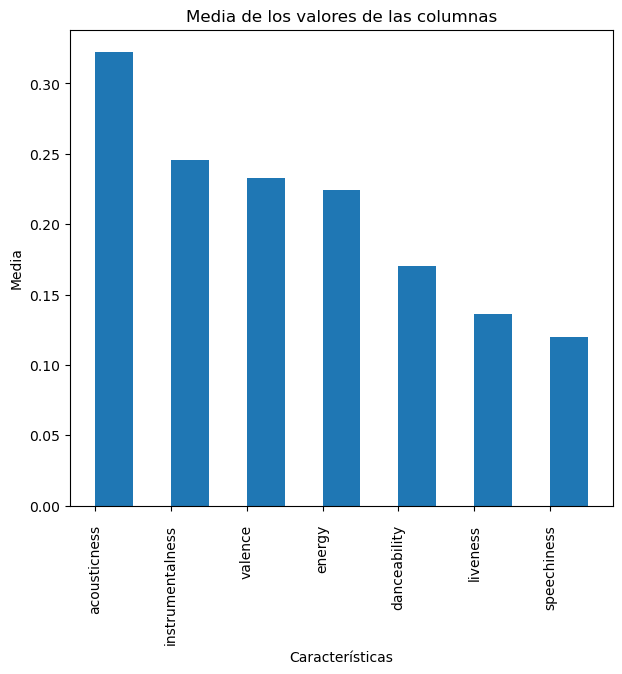

In [56]:
df_dani_std = df_dani_std.sort_values(ascending=False)


plt.bar(df_dani_std.index, df_dani_std, width=0.5, align='edge')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.tick_params(axis='x', which='major', pad=10)
plt.xlabel('Características')
plt.ylabel('Media')
plt.title('Media de los valores de las columnas')
plt.show()

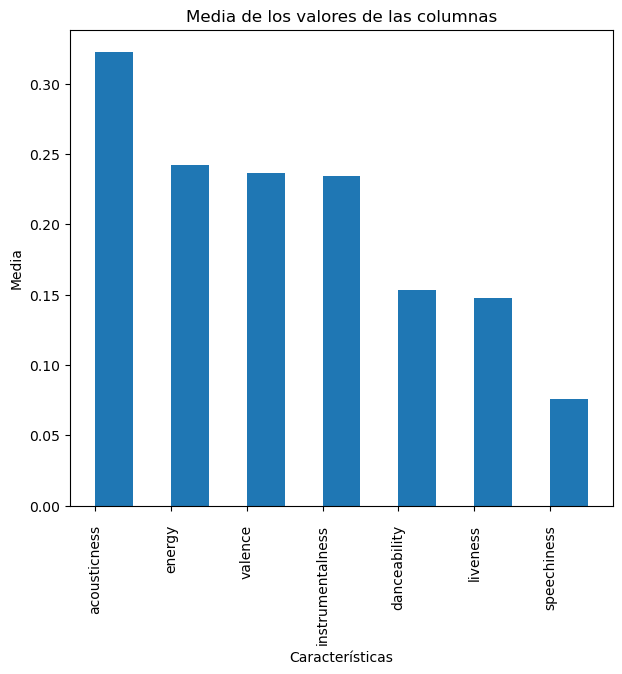

In [57]:
df_alex_std = df_alex_std.sort_values(ascending=False)


plt.bar(df_alex_std.index, df_alex_std, width=0.5, align='edge')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.tick_params(axis='x', which='major', pad=10)
plt.xlabel('Características')
plt.ylabel('Media')
plt.title('Media de los valores de las columnas')
plt.show()

In [46]:
std_alex = sum(df_alex_std.values)
std_dani = sum(df_dani_std.values)
(std_alex, std_dani)

(1.4115382359465112, 1.4506870118017285)

Por una diferencia mínima pero si sumamos todos los valores de la desviación típica podriamos asumir que la música que escucha Dani es ligeramente más variada que la escuchada por Alex. 

### ¿Quién escucha música más aburrida de los dos?

Si bien no hay una medida exacta para determinar que canción es más aburrida que otra vamos a tirar de prejuicios y determinaremos que cuanto más bailable y energética sea una canción más divertida será mientras que cuanto más discurso y más acústica sea más aburrida será. Tendremos también en cuenta el valor de 'loudness' y el tempo. 

Teniendo todo esto en consideración hemos calculado un valor que llamaremos 'aburrimiento' que viene determinado por la siguiente formula: 

aburrimiento = *(danceability x 100) + (energy x 100) + tempo + loudness

Cuánto mayor es el valor de aburrimiento, más divertida será la canción

*multiplicamos por 100 ambas variables ya que están en la escala del 0 y 1

In [58]:
df_dani['aburrimiento'] = (df_dani['danceability'] * 100 + df_dani['energy'] * 100 + df_dani['loudness'] + df_dani['tempo'])
df_alex['aburrimiento'] = (df_alex['danceability'] * 100 + df_alex['energy'] * 100 + df_alex['loudness'] + df_alex['tempo'])

In [59]:
df_dani.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist,aburrimiento
0,0.820,0.5630,91.034,0.0874,0.0536,0.00000,4,0.693,7,199451,-4.761,0.604,1,spotify:track:0X8Cti1dfb4wCRiuW7O1lA,341 Lords,Ill Pekeño,237.573
1,0.855,0.1380,168.583,0.3800,0.0844,0.00000,4,0.425,10,171429,-6.519,0.398,0,spotify:track:3JIdMvH3D07jrN0LD5LfYM,Av. Rafaela Ybarra,Ill Pekeño,290.064
2,0.646,0.1000,87.847,0.3610,0.1950,0.00000,4,0.791,4,196364,-8.586,0.589,0,spotify:track:0hwacTqU4grF4gD68dE4fj,AMG,Ill Pekeño,222.961
3,0.534,0.0949,87.215,0.3450,0.6080,0.00576,4,0.665,10,198621,-9.749,0.858,0,spotify:track:0nDFRlto0k3TTpNONZ2dWe,Calle Cortada,Ill Pekeño,197.366
4,0.601,0.3100,82.941,0.3640,0.0317,0.00000,4,0.424,9,167347,-8.153,0.416,0,spotify:track:68dxVhzivEJYn2Epw39jdh,Tierra Abatida,Ill Pekeño,177.288


In [60]:
df_dani[df_dani.aburrimiento == df_dani.aburrimiento.max()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist,aburrimiento
891,0.956,0.58,198.076,0.178,0.0281,0.0,4,0.428,8,172640,-2.382,0.686,0,spotify:track:42VgiRyg0YjtRVLiPFNxPJ,Zapatillas,El Canto Del Loco,334.094


In [61]:
df_alex[df_alex.aburrimiento == df_alex.aburrimiento.max()]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist,aburrimiento
623,0.91,0.02,191.928,0.211,0.0299,0.0,4,0.589,2,146337,-3.68,0.89,1,spotify:track:1tmwswvJnwOIrskyCKVsgv,Todos los días sale el sol,Bongo Botrako,338.148
1032,0.91,0.02,191.928,0.211,0.0299,0.0,4,0.589,2,146337,-3.68,0.89,1,spotify:track:1tmwswvJnwOIrskyCKVsgv,Todos los días sale el sol,Bongo Botrako,338.148


Vemos que algunas canciones que han salido son 'Todos los dias sale el sol' y 'Zapatillas'. Ambos son temas bastante conocidos y sí que se pueden considerar temas divertidos que suenan en cualquier fiesta popular

Ahora vamos a ver quien tiene mayor media de canciones divertidas

In [62]:
df_alex_mean_aburrimiento = df_alex.mean(numeric_only=True)['aburrimiento']
df_alex_mean_aburrimiento

230.22780556614563

In [63]:
df_dani_mean_aburrimiento = df_dani.mean(numeric_only=True)['aburrimiento']
df_dani_mean_aburrimiento

215.36084074074074

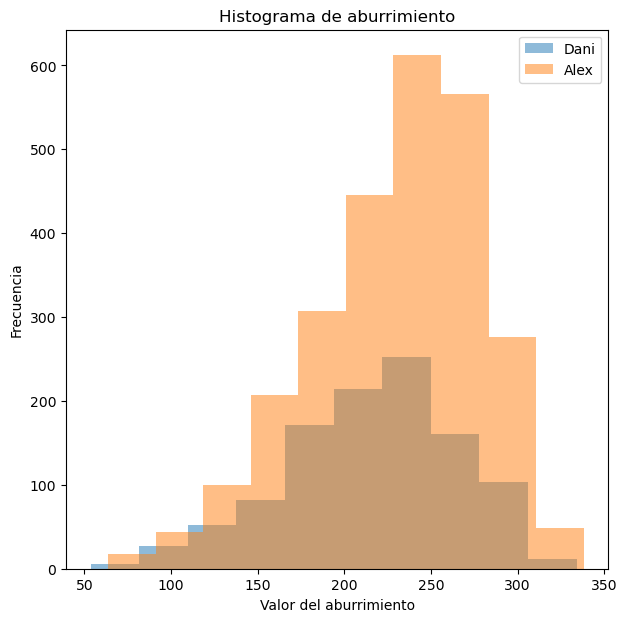

In [66]:
aburrimiento_dani = df_dani['aburrimiento']
aburrimiento_alex = df_alex['aburrimiento']

# Crea un histograma
plt.hist(aburrimiento_dani, bins=10, alpha=0.5, label="Dani")
plt.hist(aburrimiento_alex, bins=10, alpha=0.5, label="Alex")
plt.xlabel("Valor del aburrimiento")
plt.ylabel("Frecuencia")
plt.title("Histograma de aburrimiento")
plt.legend()
plt.show()

Como alex tiene más canciones la frecuencia es mayor al tener muchos más valores.
La media de 'aburrimiento' también beneficia a Alex, que obtiene una mayor puntuación por lo que de media escucha canciones más divertidas y se podría concluir que la música de Dani es ligeramente más aburrida. 

In [63]:
len(df_dani), len(df_alex)

(1080, 2623)

### Predictor de playlist

A continuación, usando machine learning vamos a desarrollar un modelo que pueda predecir si una canción pertenece a una de las playlist de Dani o a una de las playlist de Alex. 

In [70]:
df_dani['user'] = 'dani'
df_alex['user'] = 'alex'

In [76]:
df_total = pd.concat([df_dani, df_alex])

In [77]:
df_total

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,uri,name,artist,aburrimiento,user
0,0.820,0.5630,91.034,0.0874,0.0536,0.000000,4,0.693,7,199451,-4.761,0.604,1,spotify:track:0X8Cti1dfb4wCRiuW7O1lA,341 Lords,Ill Pekeño,237.573,dani
1,0.855,0.1380,168.583,0.3800,0.0844,0.000000,4,0.425,10,171429,-6.519,0.398,0,spotify:track:3JIdMvH3D07jrN0LD5LfYM,Av. Rafaela Ybarra,Ill Pekeño,290.064,dani
2,0.646,0.1000,87.847,0.3610,0.1950,0.000000,4,0.791,4,196364,-8.586,0.589,0,spotify:track:0hwacTqU4grF4gD68dE4fj,AMG,Ill Pekeño,222.961,dani
3,0.534,0.0949,87.215,0.3450,0.6080,0.005760,4,0.665,10,198621,-9.749,0.858,0,spotify:track:0nDFRlto0k3TTpNONZ2dWe,Calle Cortada,Ill Pekeño,197.366,dani
4,0.601,0.3100,82.941,0.3640,0.0317,0.000000,4,0.424,9,167347,-8.153,0.416,0,spotify:track:68dxVhzivEJYn2Epw39jdh,Tierra Abatida,Ill Pekeño,177.288,dani
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,0.442,0.1580,105.025,0.0249,0.4430,0.614000,4,0.584,9,303507,-10.994,0.360,0,spotify:track:28U855g6cGv2O3s5KzUcdr,White Flag,Fink,196.631,alex
2619,0.195,0.1010,93.071,0.0300,0.6730,0.002540,4,0.378,11,240813,-12.423,0.356,1,spotify:track:1JEjCzwE9viGiRyewkcWy9,Sleepless in Seattle,Noah Gundersen,137.948,alex
2620,0.185,0.3590,77.374,0.0311,0.9270,0.000009,4,0.423,5,205427,-9.339,0.160,1,spotify:track:3eOowx1zDomY1YC1UDKDKn,"I'm Tired, You're Lonely",Liza Anne,128.835,alex
2621,0.426,0.0976,148.063,0.0310,0.7600,0.392000,4,0.453,9,394320,-12.793,0.356,1,spotify:track:5eSH7Aubn6Ol80ynF4MV2L,Nica Libres At Dusk,Ben Howard,223.170,alex


La variable que queremos predecir es la variable 'user', que solo puede tener dos valores: Alex o Dani

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

In [80]:
train, test = train_test_split(df_total, train_size=0.8)

In [83]:
gnb = GaussianNB()
x_train = train.drop(['user', 'uri', 'artist', 'name'], axis=1) # características
y_train = train['user'] # variable a predecir

gnb.fit(x_train, y_train)
x_test = test.drop(['user', 'uri', 'artist', 'name'], axis=1) # características
y_test = test['user'] # variable a predecir

y_test_pred = gnb.predict(x_test) # score
gnb.score(x_test, y_test)

0.7004048582995951

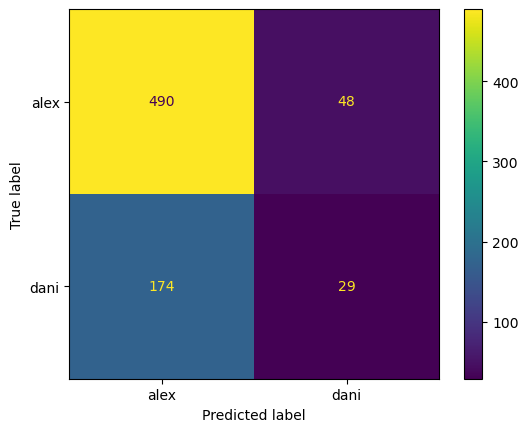

In [91]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay.from_estimator(gnb, x_test, y_test)

Viendo la matriz de confusión vemos que en la gran mayoría de casos se predice que la canción pertenece a las playlists de Alex. De 741 canciones se predicen que 664, es decir casi un 90%, pertenecen a las playlists de Alex. Esto se debe a que Alex dispone de muchas más canciones por lo que el modelo puede haber sobreaprendido

Vamos a probar el mismo modelo utilizando un dataframe que contenga las mismas canciones tanto de Dani como de Alex

In [92]:
len(df_dani), len(df_alex)

(1080, 2623)

In [96]:
num_filas = len(df_alex) - len(df_dani)
random_indices = df_alex.sample(n=num_filas, random_state=42).index
df_alex_mod = df_alex.drop(random_indices)

In [97]:
len(df_alex_mod)

1080

In [98]:
df_total_mod = pd.concat([df_dani, df_alex_mod])

In [99]:
train, test = train_test_split(df_total_mod, train_size=0.8)

In [100]:
gnb = GaussianNB()
x_train = train.drop(['user', 'uri', 'artist', 'name'], axis=1) # características
y_train = train['user'] # variable a predecir

gnb.fit(x_train, y_train)
x_test = test.drop(['user', 'uri', 'artist', 'name'], axis=1) # características
y_test = test['user'] # variable a predecir

y_test_pred = gnb.predict(x_test) # score
gnb.score(x_test, y_test)

0.5717592592592593

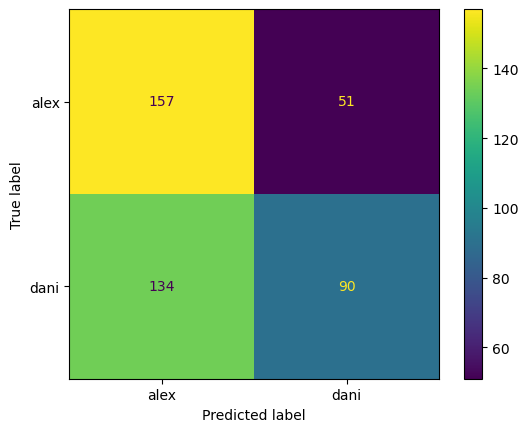

In [101]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay.from_estimator(gnb, x_test, y_test)

Si bien por un lado se ha igualado un poco el número de predicciones de un usuario respecto al otro (aunque sigue siendo superior el número de predicciones a favor de Alex), el resultado es peor que el anterior ya que solo ha obtenido una puntuación de 0.57, siguiendo este modelo. Vamos a probar otros métodos para ver si obtenemos resultados mejores. 

Pese a esto, y antes de hacerlo si es verdad que estimamos unos resultados pobres, teniendo en cuenta la no mucha disparidad que hay entre los dos usuarios, en cuanto a gusto musical se refiere

In [109]:
x_arr = df_total_mod.drop(['user', 'uri', 'artist', 'name'], axis=1) # Entrada
y_arr = df_total_mod['user'] # Salida

RANDOM_STATE = 57 # Elegimos una al azar y que sea siempre la misma
clf = DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_split=20,random_state=RANDOM_STATE)
puntuaciones = cross_validate(clf, x_arr.values, y_arr.values, scoring='accuracy', cv=10, return_train_score=True)

precision_entreno = np.mean(puntuaciones['train_score'])
precision_test = np.mean(puntuaciones['test_score'])
precision_entreno, precision_test

(0.7112654320987654, 0.6189814814814815)

In [110]:
# Para elegir los mejores parametros vamos a ver los resultados anteriores modificando los parametros 
# de 'max_depth' y 'min_samples split'


precision_entrenamiento = []
precision_test = []
for mss in range(5, 50, 5): # min_samples_split
    for md in range (2, 10, 1): # max_depth
        clf = DecisionTreeClassifier(criterion="entropy",max_depth=md,min_samples_split=mss,random_state=RANDOM_STATE)
        puntuaciones = cross_validate(clf, x_arr.values, y_arr.values, scoring='accuracy', cv=10, return_train_score=True)
    
        precision_entrenamiento.append(np.mean(puntuaciones['train_score']))
        precision_test.append(np.mean(puntuaciones['test_score']))
    

precision_entrenamiento, precision_test
print(np.argmax(precision_test))

38


Haciendo lo anterior vemos que la mejor combinación de parámetros es la que establece min_samples_split = 25 y max_depth = 8

In [111]:
clf = DecisionTreeClassifier(criterion="entropy",max_depth=8,min_samples_split=25,random_state=RANDOM_STATE)
puntuaciones = cross_validate(clf, x_arr.values, y_arr.values, scoring='accuracy', cv=10, return_train_score=True)

precision_entreno = np.mean(puntuaciones['train_score'])
precision_test = np.mean(puntuaciones['test_score'])
precision_entreno, precision_test

(0.7891975308641976, 0.6523148148148149)

De esta forma se obtiene un valor de 0.65, lo que es casi 0.1 mejor que el modelo gausiano

In [112]:
clf.fit(x_train, y_train)
y_test_pred = gnb.predict(x_test) # score
clf.score(x_test, y_test)

0.6527777777777778

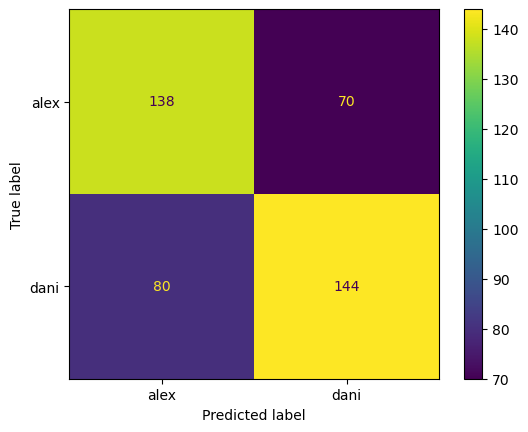

In [114]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test)

Vemos que esta matriz de confusión tiene un color mucho mejor que la anterior. En este caso está bastante igualado el número de predicciones tanto de Dani como de Alex, y se han predecido correctamente 282 de 432 canciones (65%)

Vamos a probar a usar el clasificatorio de bosque aleatorio

In [116]:
rfclf = RandomForestClassifier(n_estimators=100)
rfclf.fit(x_train.values, y_train.values)
rfclf.score(x_test.values, y_test.values)

0.7268518518518519

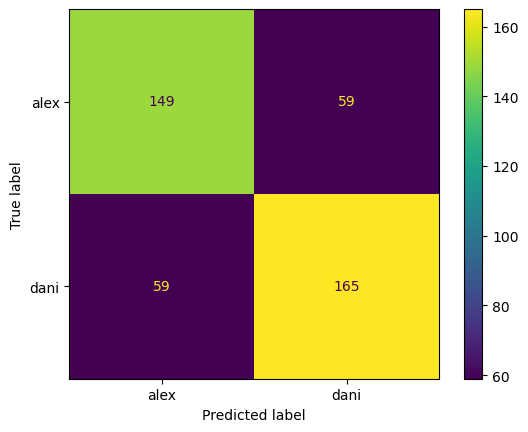

In [122]:
y_test_pred = rfclf.predict(x_test.values) # score
cf_matrix = confusion_matrix(y_test.values, y_test_pred)
ConfusionMatrixDisplay.from_estimator(rfclf, x_test.values, y_test)

De los tres modelos que hemos utilizado hemos llegado a la conclusión de que este último modelo es el que nos ha proporcionado un mejor resultado. Predice correctamente el 71% de las canciones. Teniendo en cuenta la muestra y la no gran diferencia entre ambos usuarios, se puede considerar que hemos obtenido un resultado bastante correcto

### ¿Qué artistas escuchan más cada uno de los usuarios?

In [17]:
df_dani_artistas = df_dani.groupby('artist').size().reset_index(name='num_songs')
df_dani_artistas = df_dani_artistas.sort_values(by='num_songs', ascending=False)
df_dani_artistas.head()

,artist,num_songs
209,Kanye West,70
223,L'haine,49
252,Mac Miller,32
88,Cruz Cafuné,27
175,Jaden,27


In [18]:
df_alex_artistas = df_alex.groupby('artist').size().reset_index(name='num_songs')
df_alex_artistas = df_alex_artistas.sort_values(by='num_songs', ascending=False)
df_alex_artistas.head()

,artist,num_songs
679,Linkin Park,53
1175,Three Days Grace,43
162,C. Tangana,39
371,Fito y Fitipaldis,38
437,Hans Zimmer,35


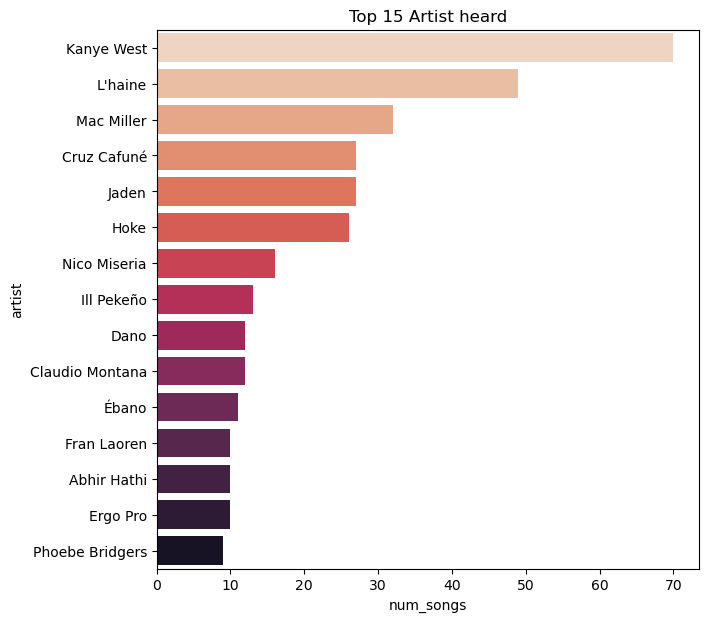

In [25]:
dani_artistas = df_dani_artistas.head(15) # Nos quedamos con los 15 artistas más guardados
plt.rcParams["figure.figsize"] = (7, 7)
sns.barplot(y = dani_artistas['artist'], x = dani_artistas['num_songs'], palette='rocket_r')
plt.title('Top 15 Artist heard')
plt.show()

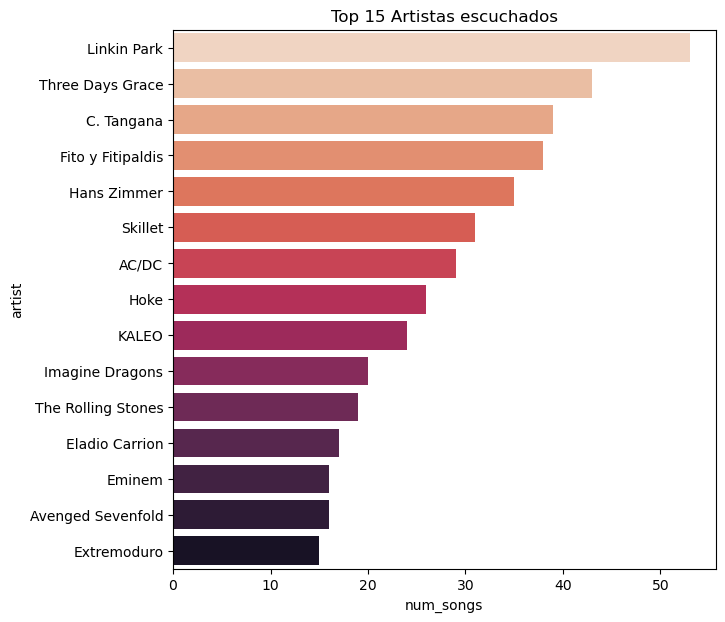

In [26]:
alex_artistas = df_alex_artistas.head(15) # Nos quedamos con los 15 artistas más guardados
plt.rcParams["figure.figsize"] = (7, 7)
sns.barplot(y = alex_artistas['artist'], x = alex_artistas['num_songs'], palette='rocket_r')
plt.title('Top 15 Artistas escuchados')
plt.show()

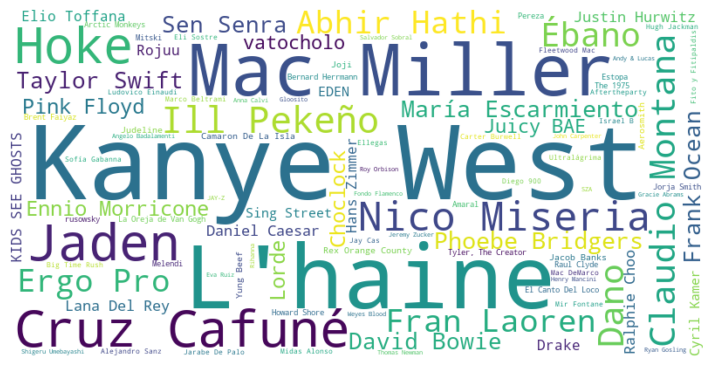

In [37]:
dani_freq = dict(zip(df_dani_artistas['artist'].tolist(), df_dani_artistas['num_songs'].tolist()))

wc = WordCloud(background_color='white',width=800, height=400, max_words=100).generate_from_frequencies(dani_freq)
plt.figure(figsize=(9, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

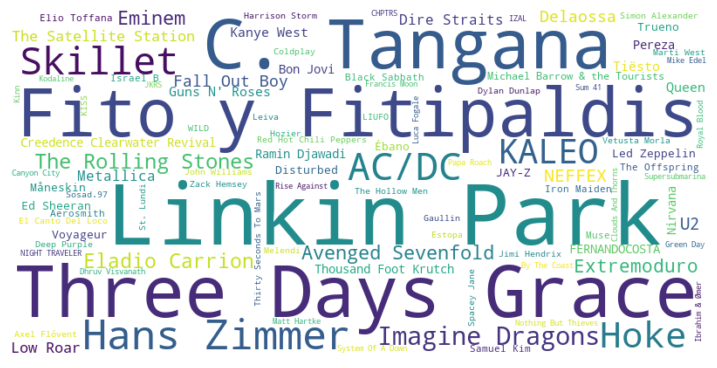

In [36]:
alex_freq = dict(zip(df_alex_artistas['artist'].tolist(), df_alex_artistas['num_songs'].tolist()))

wc = WordCloud(background_color='white',width=800, height=400, max_words=100).generate_from_frequencies(alex_freq)
plt.figure(figsize=(9, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Aquí hemos probado distintas técnicas para mostrar los artistas más escuchados, o por lo menos más guardados en las playlists, tanto de Dani como de Alex. 

Usando wordcloud podemos mostrar de forma atractiva los artistas más guardados, que serán aquellos cuyo nombre ocupe más espacio dentro de la nube. Como vemos en la nube de Alex, los nombres que aparecen con mayor tamaño coinciden con sus más escuchados (Linkin Park, Three Days Grace, Fito y los Fitipaldis...)

### Histogramas de todas las características

Siguiendo con el análisis vamos a mostrar ahora los histogramas de cada característica para los dos usuarios y a extraer conclusiones a partir de ellos

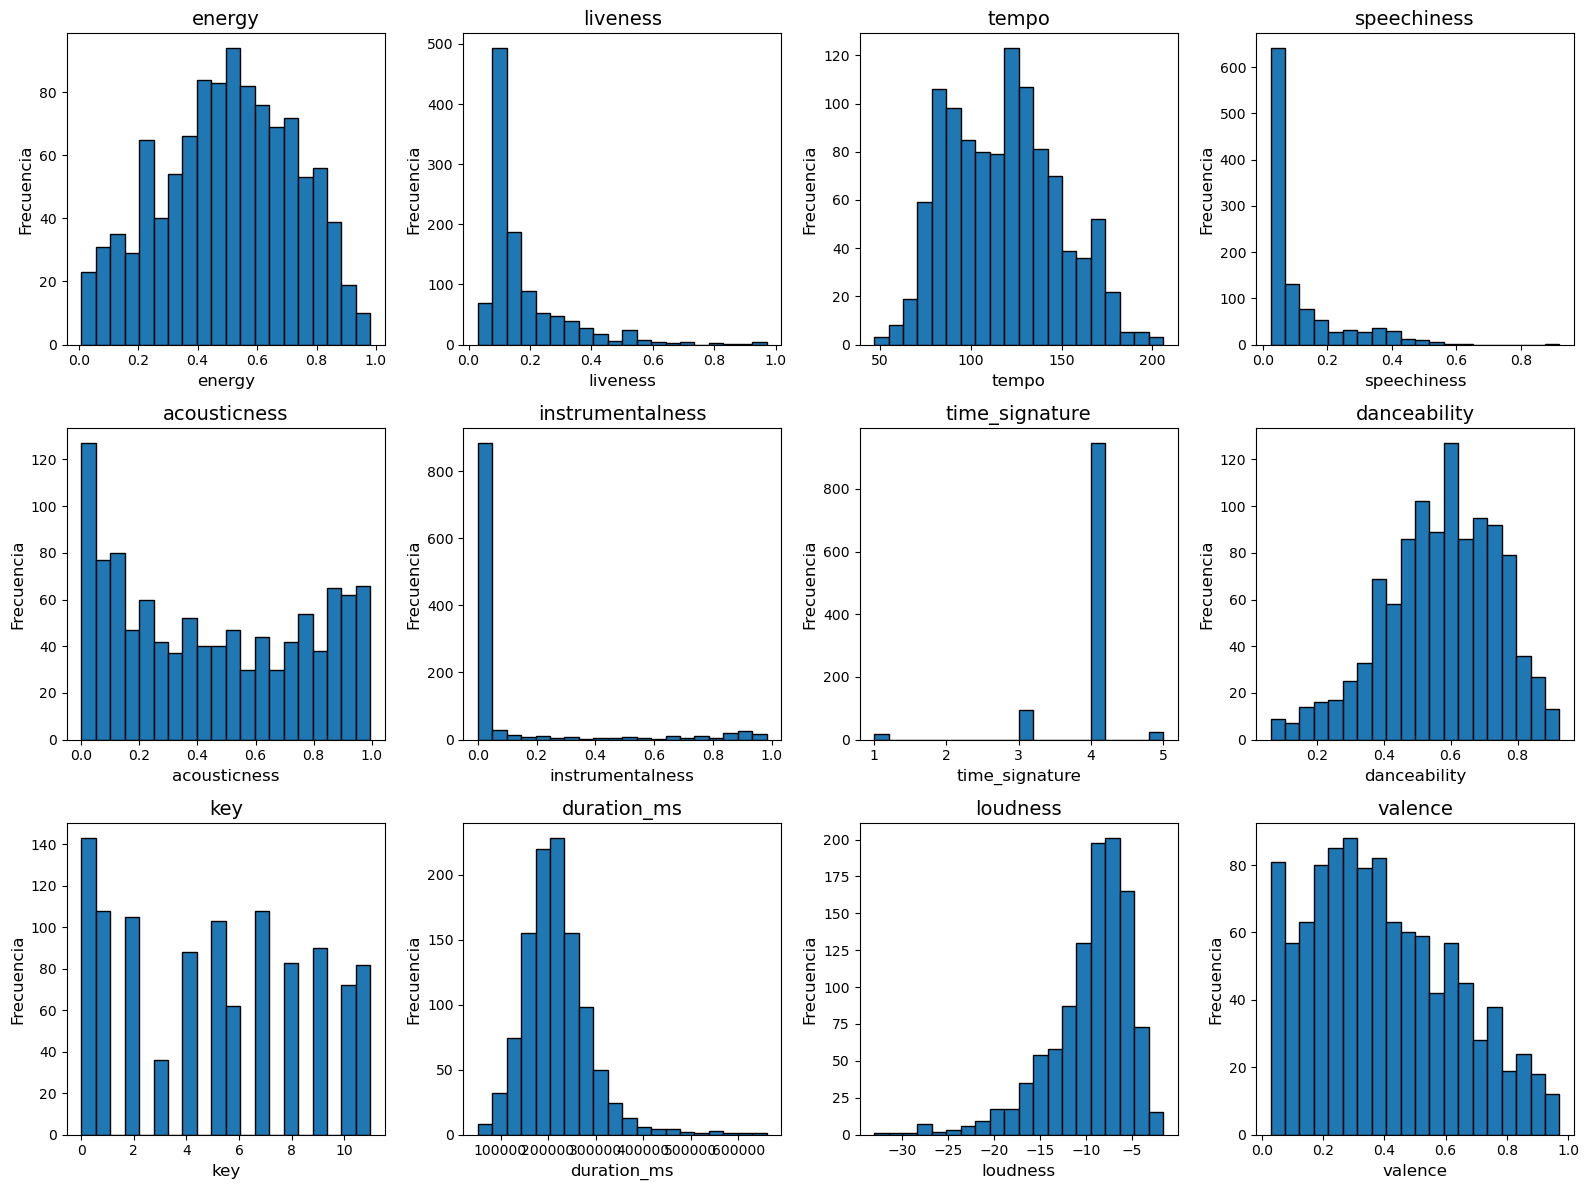

In [43]:
# Dani
num_cols = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'time_signature', 'danceability', 'key', 'duration_ms', 'loudness', 'valence']
df_num = df_dani[num_cols]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
for i, ax in enumerate(axs.flatten()):
    if i < len(num_cols):
        ax.hist(df_num[num_cols[i]], bins=20, color='tab:blue', edgecolor='black')
        ax.set_xlabel(num_cols[i], fontsize=12)
        ax.set_ylabel('Frecuencia', fontsize=12)
        ax.set_title(num_cols[i], fontsize=14)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

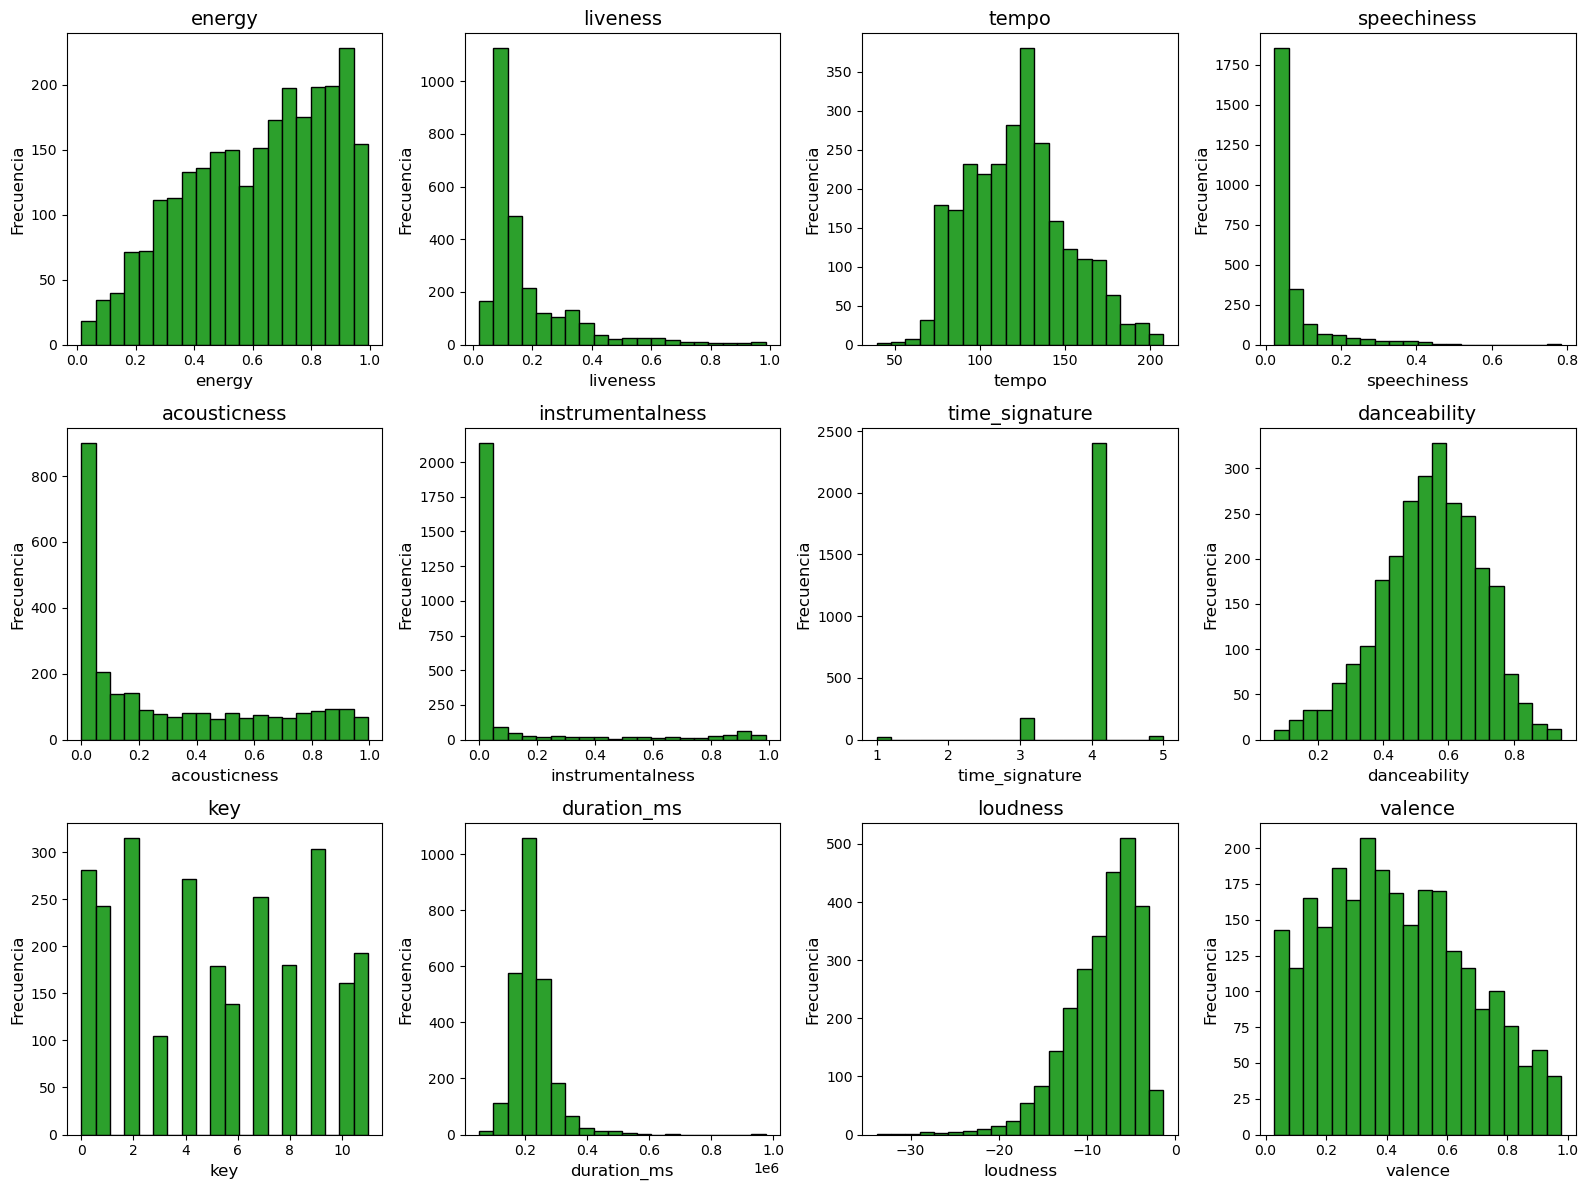

In [47]:
# Alex
num_cols = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'time_signature', 'danceability', 'key', 'duration_ms', 'loudness', 'valence']
df_num = df_alex[num_cols]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
for i, ax in enumerate(axs.flatten()):
    if i < len(num_cols):
        ax.hist(df_num[num_cols[i]], bins=20, color='tab:green', edgecolor='black')
        ax.set_xlabel(num_cols[i], fontsize=12)
        ax.set_ylabel('Frecuencia', fontsize=12)
        ax.set_title(num_cols[i], fontsize=14)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

Vamos a analizar y comparar cada una de las características:
- Energy: Vemos que Alex tiene una mayor frecuencia a escuchar canciones enérgicas. El valor más frecuente en la música de Alex está en torno al 0.9 mientras que el de Dani está cercano al 0.5. Como hemos visto al principio también, la energía era uno de los factores que más diferenciaban ambos gustos musicales, beneficiando claramente a Alex
- Liveness: En este caso la diferencia es escasísima entre los dos usuarios por lo que no merece la pena comparar este aspecto
- Tempo: Aquí se puede apreciar una mayor frecuencia en el caso de Dani en torno a los valores algo más bajos que los de Alex. Aunque pasa algo curioso y es que en la música de Dani se presenta una mayor frecuencia tanto en los valores bajos como en los altos por lo que en cuanto al tempo se refiere se podría decir que la música de Dani es más variada
- Speechiness: Vuelve a pasar lo mismo que en Liveness, que la diferencia es tan escasa que no es interesante comparar ambos valores
- Acousticness: Aquí apreciamos una gran diferencia en ambos casos, aunque también puede ser debido a que el dataset de canciones de Dani contiene casi 1500 canciones menos. Como podemos ver, los valores en el primer caso están mucho más dispersos que en el caso de Alex, aunque en ambos predomina el valor más bajo posible. Sin embargo, en el caso de Alex predomina mucho más que en el otro. Aunque si nos fijamos en los números podemos ver que lo que hemos dicho al principio iba bien encaminado.
- Instrumentalness: De nuevo, apenas hay diferencia en este caso
- Time_signature: Lo mismo
- Danceability: Aquí volvemos a ver una tendencia favorable a la música de Dani, que tiene mayor frecuencia en valores altos por lo que, como hemos visto más arriba, Dani suele escuchar canciones más bailables que Alex, aunque la diferencia no es tan grande como para poder asegurar que uno sí escucha canciones bailables mientras el otro apenas las escucha. 
- Key: Esta característica presenta pocas diferencias en ambos usuarios
- Duration_ms: Viendo el resultado de abajo y las gráficas de arriba, no hay mucha diferencia pero Alex tiene la tendencia a escuchar canciones más largas, aunque la diferencia sea mínimo. Esto tiene sentido teniendo en cuenta los gustos de Alex y los míos, ya que los géneros que él suele escuchar (rock) suelen tener canciones más largas que los géneros que suele escuchar Dani (urbano), que son más cortas
- Loudness: Vuelve a haber muy poca diferencia en ambos casos. Puede parecer que la música de Dani tiene mayor frecuencia en los valores medios pero se debe otra vez a la diferencia de tamaños en ambos datasets
- Valence: Como vimos más arriba al mostrar en un diagrama de barras las diferencias, la música de Alex suele ser más positiva si tenemos únicamente en cuenta este valor. También podemos ver en estos histogramas que en el caso de Dani, hay mayor frecuencia en el valor mínimo que en el caso de Alex

In [49]:
df_dani['duration_ms'].mean(), df_alex['duration_ms'].mean()

(217708.74351851852, 222975.57948913457)